# Sources
* [usuyama/pytorch-unet](https://github.com/usuyama/pytorch-unet) from this repo we used training loop, simulated dataset, and other helpers for visualization.
* [milesial/PyTorch-Unet](https://github.com/milesial/Pytorch-UNet/tree/master/unet) from this repo we used the `unet` module for neural network architecture.
* [Original UNet paper](https://arxiv.org/pdf/1505.04597.pdf)
* For more information on Dice loss and Binary Cross Entropy loss see the notebook `dice_loss_bce_loss.ipynb`.


![alt text](UNet.png "UNet")

# Visualize input dataset

(3, 192, 192, 3)
0 255
(3, 6, 192, 192)
0.0 1.0


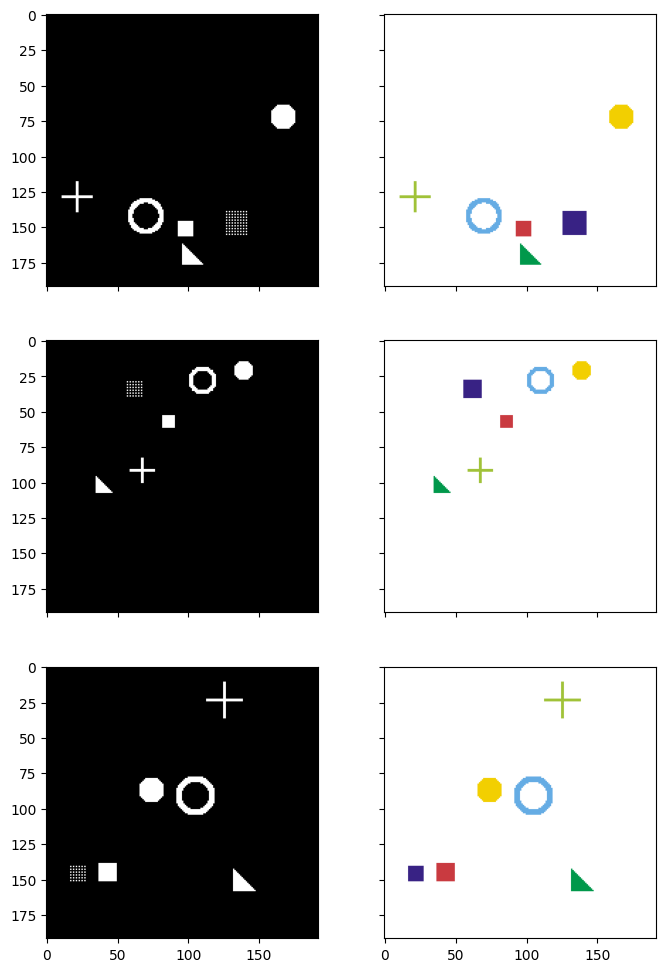

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import helper
import simulation

# Generate some random images
input_images, target_masks = simulation.generate_random_data(192, 192, count=3)

for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

# Left: Input image (black and white), Right: Target mask (6ch)
helper.plot_side_by_side([input_images_rgb, target_masks_rgb])

# Prepare Dataset and Dataloader

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)
        self.transform = transform

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)

        return [image, mask]

# use the same transformations for train/val in this example
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

train_set = SimDataset(2000, transform = trans)
val_set = SimDataset(200, transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

# Check the output from Dataloader

torch.Size([25, 3, 192, 192]) torch.Size([25, 6, 192, 192])


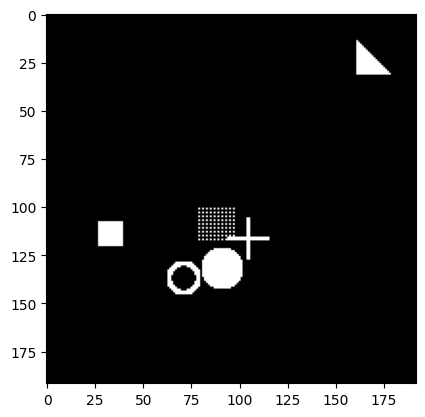

In [3]:
import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)

plt.imshow(reverse_transform(inputs[3]))

# Prepare a `UNet` model

In [4]:
from unet import UNet
import torch

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =  net = UNet(n_channels=3, n_classes=6, bilinear=True)
model = model.to(device)

# check keras-like model summary using torchsummary
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
        DoubleConv-7         [-1, 64, 224, 224]               0
         MaxPool2d-8         [-1, 64, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]          73,728
      BatchNorm2d-10        [-1, 128, 112, 112]             256
             ReLU-11        [-1, 128, 112, 112]               0
           Conv2d-12        [-1, 128, 112, 112]         147,456
      BatchNorm2d-13        [-1, 128, 112, 112]             256
             ReLU-14        [-1, 128, 1

# Define the main training loop

In [6]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Training

In [7]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 6
#model = model(num_class).to(device)

# freeze backbone layers
#for l in model.base_layers:
#    for param in l.parameters():
#        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=60)

cuda:0
Epoch 0/59
----------
LR 0.0001


/home/ruthvik/pytorch_1121_cu113_unet/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/ruthvik/pytorch_1121_cu113_unet/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.514121, dice: 0.979471, loss: 0.746796
val: bce: 0.459575, dice: 0.977623, loss: 0.718599
saving best model
0m 24s
Epoch 1/59
----------
LR 0.0001
train: bce: 0.414441, dice: 0.974459, loss: 0.694450
val: bce: 0.379762, dice: 0.972408, loss: 0.676085
saving best model
0m 25s
Epoch 2/59
----------
LR 0.0001
train: bce: 0.346147, dice: 0.970363, loss: 0.658255
val: bce: 0.314018, dice: 0.968091, loss: 0.641054
saving best model
0m 25s
Epoch 3/59
----------
LR 0.0001
train: bce: 0.286223, dice: 0.965362, loss: 0.625792
val: bce: 0.260262, dice: 0.962879, loss: 0.611570
saving best model
0m 25s
Epoch 4/59
----------
LR 0.0001
train: bce: 0.236052, dice: 0.958850, loss: 0.597451
val: bce: 0.214615, dice: 0.955372, loss: 0.584994
saving best model
0m 25s
Epoch 5/59
----------
LR 0.0001
train: bce: 0.193300, dice: 0.950856, loss: 0.572078
val: bce: 0.174865, dice: 0.946818, loss: 0.560842
saving best model
0m 25s
Epoch 6/59
----------
LR 0.0001
train: bce: 0.158289, dice: 0.9412

val: bce: 0.000656, dice: 0.036249, loss: 0.018452
saving best model
0m 25s
Epoch 52/59
----------
LR 1e-05
train: bce: 0.000264, dice: 0.027797, loss: 0.014030
val: bce: 0.000658, dice: 0.036220, loss: 0.018439
saving best model
0m 25s
Epoch 53/59
----------
LR 1e-05
train: bce: 0.000259, dice: 0.027258, loss: 0.013758
val: bce: 0.000652, dice: 0.035546, loss: 0.018099
saving best model
0m 25s
Epoch 54/59
----------
LR 1e-05
train: bce: 0.000253, dice: 0.026694, loss: 0.013473
val: bce: 0.000642, dice: 0.034780, loss: 0.017711
saving best model
0m 25s
Epoch 55/59
----------
LR 1e-05
train: bce: 0.000248, dice: 0.026193, loss: 0.013220
val: bce: 0.000647, dice: 0.034490, loss: 0.017568
saving best model
0m 25s
Epoch 56/59
----------
LR 1e-05
train: bce: 0.000243, dice: 0.025665, loss: 0.012954
val: bce: 0.000636, dice: 0.034366, loss: 0.017501
saving best model
0m 25s
Epoch 57/59
----------
LR 1e-05
train: bce: 0.000238, dice: 0.025149, loss: 0.012694
val: bce: 0.000623, dice: 0.033226

# Using the trained model 

(3, 6, 192, 192)


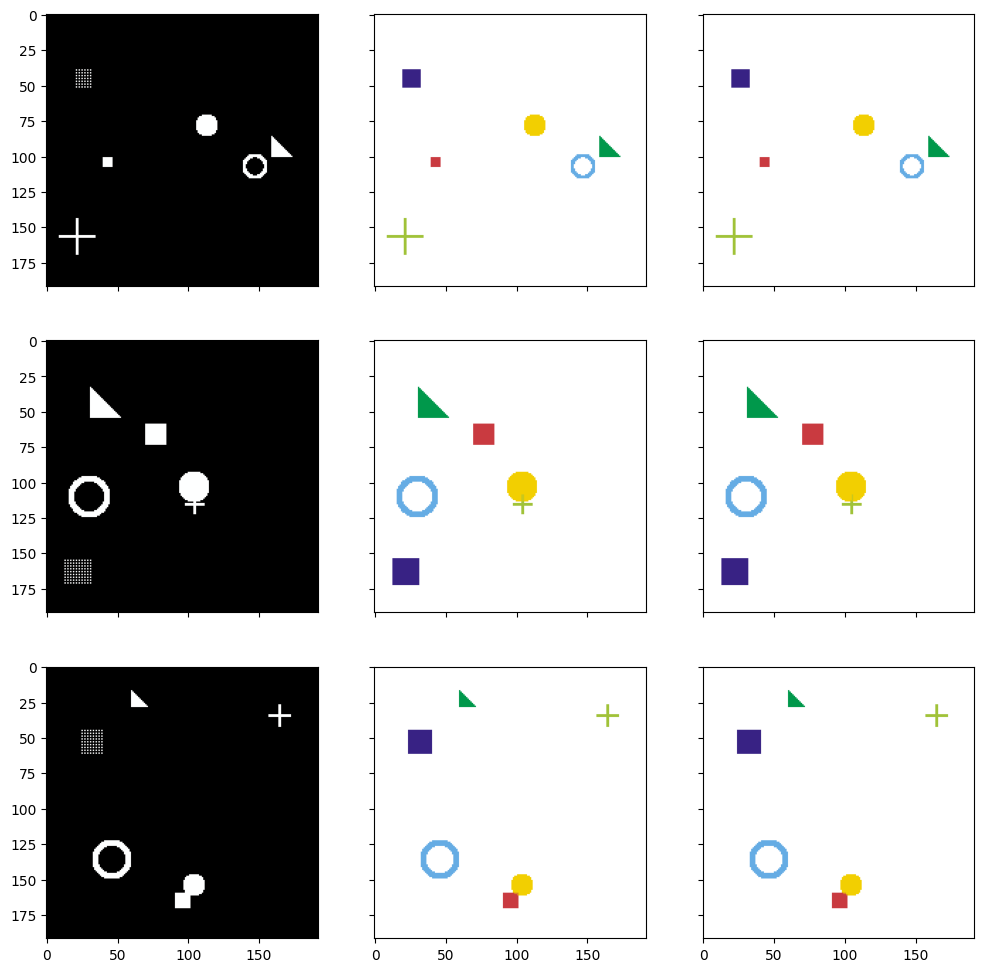

In [12]:
import math

model.eval()   # Set model to the evaluation mode

# Create another simulation dataset for test
test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)

# Get the first batch
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = F.sigmoid(pred)
pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])
#Left: Input image, Middle: Correct mask (Ground-truth), Rigth: Predicted mask